In [1]:
import re
import os
import json
import codecs
import numpy as np
import pandas as pd
import random
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
rawPath="E:/project/xc_KG/EandR/code/process/data/8yueC_id.csv"
dataPath="./rawdata/test_data.csv"
dictSaveDir='./rawdata'

In [4]:
def csvToStandard(rawPath, savePath="./rawdata/8yuedataC_id.csv", names=["head", "relation", "tail"], header=0, sep=",", encoding="utf_8_sig", compression="infer"):
    print("INFO : Loading data of type %s" % os.path.splitext(rawPath)[-1])
    rawDf = pd.read_csv(rawPath,
                        sep=sep,
                        encoding=encoding,
                        names=names,
                        header=header,
                        keep_default_na=False,  # ==> Solve default nan
                        compression=compression,# ==> Solve ZIP and TAR
                        error_bad_lines=False,  # ==> Solve inconsistent lines
                        warn_bad_lines=False,   # ==> Solve inconsistent lines
                        skip_blank_lines=True)  # ==> Solve blank lines
    print(rawDf)
    print("INFO : Remove the space from the head and tail of entity.")
    rawDf = rawDf.applymap(lambda x: x.strip())  # Rid of the space in head and tail of entity
    print("INFO : Drop line with nan value.")    # Attention: " " should be removed.
    rawDf.replace({'': np.nan}, inplace=True)
    rawDf.dropna(axis=0, how='any', inplace=True)   #存在空格的行全部去掉

    print("INFO : Save standard data to file path : %s" % savePath)
    rawDf.to_csv(savePath, sep="\t", index=None, encoding="utf_8_sig")  
    print("INFO : Successfully saving!")


In [ ]:
csvToStandard(rawPath)

In [2]:
import math
import json
import numpy as np
import pandas as pd
from torch.utils.data import *

In [3]:
entityDictPath='./rawdata/entityDict.json'
relationDictPath='./rawdata/relationDict.json'
posDataPath='./rawdata/test_data_norm.csv'

In [4]:
#去除初始测试集中训练集词典不含的实体和关系
entitydict=json.load(open(entityDictPath, "r",encoding='utf_8_sig'))["stoi"]  
relationdict=json.load(open(relationDictPath, "r",encoding='utf_8_sig'))["stoi"]
entitylist=list(entitydict.keys())
relationlist=list(relationdict.keys())
# df=pd.read_csv(posDataPath,sep="\t",encoding="utf_8_sig")
# print(len(df))
# df.head=df['head'].apply(lambda x:np.nan if x not in entitylist else x)  #筛选
# df.tail=df['tail'].apply(lambda x:np.nan if x not in entitylist else x)
# df.relation=df.relation.apply(lambda x:np.nan if x not in relationlist else x)
# df=df.dropna(axis=0,how="any")
# print(len(df))
# df.to_csv("./rawdata/test_data_norm.csv", sep="\t", index=None, encoding="utf_8_sig") 

In [5]:
entitylist=json.load(open(entityDictPath, "r",encoding='utf_8_sig'))["itos"]   #包含所有实体的列表
relationlist=json.load(open(relationDictPath, "r",encoding='utf_8_sig'))["itos"] #包含所有关系的列表

In [ ]:
class tripleDataset(Dataset):
    def __init__(self, entityDictPath, relationDictPath, posDataPath):  #posdatapath测试集路径
        super(Dataset, self).__init__()
        # Load entity-index dict and relation-index dict
        print("INFO : Load entity and relation dict.")
        self.entityDict = json.load(open(entityDictPath, "r",encoding='utf_8_sig'))["stoi"]    #{word:ind} of entity
        self.relationDict = json.load(open(relationDictPath, "r",encoding='utf_8_sig'))["stoi"]#{word:ind} of relationship

        # Transform entity and relation to index
        print("INFO : Loading positive triples and transform to index.")
        self.posDf = pd.read_csv(posDataPath,                             #trainning data/ type:dataframe
                                 sep="\t",
#                                  names=["head", "relation", "tail"],
#                                  header=None,
                                 encoding="utf_8_sig",
                                 keep_default_na=False)


        self.transformToIndex(self.posDf, repDict={"head":self.entityDict,
                                                   "relation":self.relationDict,
                                                   "tail":self.entityDict})

    def generateNegSamples(self, repProba=0.5, exProba=0.5, repSeed=0, exSeed=0, headSeed=0, tailSeed=0):  #用于生成负样本
        assert repProba >= 0 and repProba <= 1.0 and exProba >= 0 and exProba <= 1.0
        # Generate negtive samples from positive samples
        print("INFO : Generate negtive samples from positive samples.")
        self.negDf = self.posDf.copy()          #此处copy正样本三元组进行负样本集的初始化
        np.random.seed(repSeed)
        repProbaDistribution = np.random.uniform(low=0.0, high=1.0, size=(len(self.negDf), ))
        np.random.seed(exSeed)
        exProbaDistribution = np.random.uniform(low=0.0, high=1.0, size=(len(self.negDf), ))
        shuffleHead = self.negDf["head"].sample(frac=1.0, random_state=headSeed)
        shuffleTail = self.negDf["tail"].sample(frac=1.0, random_state=tailSeed)  #打乱了顺序，头尾实体顺序打乱，关系不动，所以每行的三元组已经为反例

        # Replacing head or tail
        def replaceHead(relHead, shuffHead, shuffTail, repP, exP):
            if repP >= repProba:
                '''
                Not replacing head.self.negD
                '''
                return relHead
            else:
                if exP > exProba:
                    '''
                    Replacing head with shuffle head.
                    '''
                    return shuffHead
                else:
                    '''
                    Replacing head with shuffle tail.
                    '''
                    return shuffTail
        def replaceTail(relTail, shuffHead, shuffTail, repP, exP):
            if repP < repProba:
                '''
                Not replacing tail.
                '''
                return relTail
            else:
                if exP > exProba:
                    '''
                    Replacing tail with shuffle tail.
                    '''
                    return shuffTail
                else:
                    '''
                    Replacing head with shuffle head.
                    '''
                    return shuffHead

        # 得到了头尾实体仅替换掉一个的负样本集
        self.negDf["head"] = list(map(replaceHead, self.negDf["head"], shuffleHead, shuffleTail, repProbaDistribution, exProbaDistribution))
        self.negDf["tail"] = list(map(replaceTail, self.negDf["tail"], shuffleHead, shuffleTail, repProbaDistribution, exProbaDistribution))

  
    @staticmethod   #静态方法   将posDF中的元素转为entity、relation字典中的values
    def transformToIndex(csvData:pd.DataFrame, repDict:dict): #函数参数中的冒号是参数的类型建议符，告诉程序员希望传入的实参的类型
        for col in repDict.keys():    #key为head，relation,tail
            csvData[col] = csvData[col].apply(lambda x:repDict[col][x])

    def __len__(self):
        return len(self.posDf)

    def __getitem__(self, item):
        if hasattr(self, "negDf"):
            return np.array(self.posDf.iloc[item,:3]), np.array(self.negDf.iloc[item,:3])  #序列索引，返回3列   包含正样本和负样本的元组
        else:
            return np.array(self.posDf.iloc[item,:3])

In [ ]:
dataset=tripleDataset(entityDictPath,relationDictPath,posDataPath)
dataset.generateNegSamples()

In [6]:
import torch
import codecs
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [7]:
import os
import json
import torch
import codecs
import pickle
import argparse
import numpy as np
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tensorboardX import SummaryWriter

In [ ]:
dataloader = DataLoader(dataset,
                        batch_size=1024,
                        shuffle=True,
#                         num_workers=1,
                        drop_last=True)

In [10]:
class TransH(nn.Module):
    def __init__(self, entityNum, relationNum, embeddingDim, margin=1.0, L=2, C=1.0, eps=0.003):
        super(TransH, self).__init__()
        assert (L in [1, 2])
        self.model = "TransH"
        self.entnum = entityNum
        self.relnum = relationNum
        self.margin = margin
        self.L = L
        self.C = C
        self.eps = eps  #学习率

        self.entityEmbedding = nn.Embedding(num_embeddings=entityNum,
                                            embedding_dim=embeddingDim)
        self.relationEmbedding = nn.Embedding(num_embeddings=relationNum,
                                              embedding_dim=embeddingDim)
        self.relationHyper = nn.Embedding(num_embeddings=relationNum,
                                          embedding_dim=embeddingDim)
        self.distfn = nn.PairwiseDistance(L)

    '''
    Calculate the score:
    Step1 : Split the triple as head, relation and tail
    Step2 : Transform index tensor to embedding tensor
    Step3 : Project entity head and tail embedding to relation hyperplane
    Step4 : Calculate similarity score in relation hyperplane
    Step5 : Return the score
    '''
    def scoreOp(self, inputTriple):
        # Step1
        head, relation, tail = torch.chunk(inputTriple,
                                           chunks=3,
                                           dim=1)   #返回整型的tensor，可以作为Embedding的索引
        # Step2
        head = torch.squeeze(self.entityEmbedding(head), dim=1)   #shape(N,dim)
        relHyper = torch.squeeze(self.relationHyper(relation), dim=1)
        relation = torch.squeeze(self.relationEmbedding(relation), dim=1)
        tail = torch.squeeze(self.entityEmbedding(tail), dim=1)
        # Step3
        head = head - relHyper * torch.sum(head * relHyper, dim=1, keepdim=True) # *为逐元乘法，配合sum为点积
        tail = tail - relHyper * torch.sum(tail * relHyper, dim=1, keepdim=True)
        # Step4
        return self.distfn(head+relation, tail)


    def retEvalWeights(self):
        return {"entityEmbed": self.entityEmbedding.weight.detach().cpu().numpy(),
                "relationEmbed": self.relationEmbedding.weight.detach().cpu().numpy(),
                "hyperEmbed": self.relationHyper.weight.detach().cpu().numpy()}

    def forward(self, posX, negX):
        size = posX.size()[0]
        # Calculate score
        posScore = self.scoreOp(posX)
        negScore = self.scoreOp(negX)

        # Get margin ranking loss
        # max(posScore-negScore+margin, 0)
        # Use F.relu()
        marginLoss = torch.sum(F.relu(input=posScore-negScore+self.margin))
        entityLoss = torch.sum(F.relu(torch.norm(self.entityEmbedding.weight, p=2, dim=1, keepdim=False)-1)) #实体向量的长度，二范数大于一就有惩罚
        orthLoss = torch.sum(F.relu(torch.sum(self.relationHyper.weight * self.relationEmbedding.weight, dim=1, keepdim=False) / \
                                    torch.norm(self.relationEmbedding.weight, p=2, dim=1, keepdim=False) - self.eps ** 2))
        return  marginLoss/size +self.C*(entityLoss/self.entnum + orthLoss/self.relnum)

In [8]:
class TransD(nn.Module):
    def __init__(self, entityNum, relationNum, entityDim, relationDim, margin=1.0, L=2):
        super(TransD, self).__init__()
        self.model = "TransD"
        self.margin = margin
        self.L = L

        # Initialize the entity and relation embedding and projection embedding
        self.entityEmbedding = nn.Embedding(num_embeddings=entityNum,
                                            embedding_dim=entityDim)
        self.entityMapEmbedding = nn.Embedding(num_embeddings=entityNum,
                                             embedding_dim=entityDim)
        self.relationEmbedding = nn.Embedding(num_embeddings=relationNum,
                                              embedding_dim=relationDim)
        self.relationMapEmbedding = nn.Embedding(num_embeddings=relationNum,
                                                 embedding_dim=relationDim)

        self.distfn = nn.PairwiseDistance(L)

    '''
    Calculate the score, steps are follows:
    Step1: Split input triples as head, relation and tail
    Step2: Calculate the mapping matrix Mrh and Mrt
    Step3: Calculate the mapping vector of head and tail
    Step4: Return the score
    '''
    def scoreOp(self, inputTriples):
        head, relation, tail = torch.chunk(inputTriples,
                                           chunks=3,
                                           dim=1)
        headp = torch.squeeze(self.entityMapEmbedding(head), dim=1)   # (B, 1, En) -> (B, En)
        head = torch.squeeze(self.entityEmbedding(head), dim=1)       # (B, 1, En) -> (B, En)
        tailp = torch.squeeze(self.entityMapEmbedding(tail), dim=1)   # (B, 1, En) -> (B, En)
        tail = torch.squeeze(self.entityEmbedding(tail), dim=1)       # (B, 1, En)  -> (B, En)
        relationp = torch.squeeze(self.relationMapEmbedding(relation), dim=1) # (B, 1, Em) -> (B, Em)
        relation = torch.squeeze(self.relationEmbedding(relation), dim=1)     # (B, 1, Em) -> (B, Em)

        '''
        relationp(B, Em) -> relationp(B, Em, 1)
        headp(B, En) -> headp(B, 1, En)
        tailp(B, En) -> tailp(B, 1, En)
        (B, Em, 1) * (B, 1, En) -> (B, Em, En)
        '''
        relatioDim = relation.size()[1]
        entityDim = head.size()[1]
        relationp = torch.unsqueeze(relationp, dim=2)   # (B, Em, 1)
        headp = torch.unsqueeze(headp, dim=1)           # (B, 1, En)
        tailp = torch.unsqueeze(tailp, dim=1)           # (B, 1, En)
        if inputTriples.is_cuda:
            Mrh = torch.matmul(relationp, headp) + torch.eye(relatioDim, entityDim).cuda(inputTriples.device.index)
            Mrt = torch.matmul(relationp, tailp) + torch.eye(relatioDim, entityDim).cuda(inputTriples.device.index)
        else:
            Mrh = torch.matmul(relationp, headp) + torch.eye(relatioDim, entityDim)
            Mrt = torch.matmul(relationp, tailp) + torch.eye(relatioDim, entityDim)
        # Map head and tail with mapping Matrix Mrh and Mrt
        # Mrh, Mrt : (B, Em, En)
        # head, tail : (B, En) -> (B, En, 1)
        # (B, Em, En) * (B, En, 1) -> (B, Em, 1)
        head = torch.unsqueeze(head, dim=2)
        tail = torch.unsqueeze(tail, dim=2)
        head = torch.squeeze(torch.matmul(Mrh, head), dim=2)   # (B, Em, 1) -> (B, Em)
        tail = torch.squeeze(torch.matmul(Mrt, tail), dim=2)   # (B, Em, 1) -> (B, Em)
        output = self.distfn(head+relation, tail)
        return output

    '''
    Normalize embedding
    '''
    def normalizeEmbedding(self):
        self.entityEmbedding.weight.data.copy_(torch.renorm(input=self.entityEmbedding.weight.detach().cpu(),
                                                            p=2,
                                                            dim=0,
                                                            maxnorm=1))
        self.relationEmbedding.weight.data.copy_(torch.renorm(input=self.relationEmbedding.weight.detach().cpu(),
                                                              p=2,
                                                              dim=0,
                                                              maxnorm=1))

    '''
    Return evaluation weights
    '''
    def retEvalWeights(self):
        return {"entityEmbed": self.entityEmbedding.weight.detach().cpu().numpy(),
                "relationEmbed": self.relationEmbedding.weight.detach().cpu().numpy(),
                "entityMapEmbed": self.entityMapEmbedding.weight.detach().cpu().numpy(),
                "relationMapEmbed": self.relationMapEmbedding.weight.detach().cpu().numpy()}

    def forward(self, posX, negX):
        size = posX.size()[0]

        # Calculate score
        posScore = self.scoreOp(posX)
        negScore = self.scoreOp(negX)

        return torch.sum(F.relu(input=posScore-negScore+self.margin)) / size


In [11]:
entityNum=len(json.load(open(entityDictPath, "r",encoding='utf_8_sig'))["stoi"])
relationNum=len(json.load(open(relationDictPath, "r",encoding='utf_8_sig'))["stoi"])
test_transH=TransH(entityNum,relationNum,14)
test_transh=TransH(entityNum,relationNum,36)
test_transh.load_state_dict(torch.load('E:/project/xc_KG/EandR/code/process/data/transH36AC_id'))
test_transH.load_state_dict(torch.load('E:/project/xc_KG/EandR/code/process/data/transH14_id'))

<All keys matched successfully>

In [26]:
test_transD=TransD(entityNum,relationNum,32,32)   #transD的测试
# test_transD.load_state_dict(torch.load('E:/project/xc_KG/EandR/code/process/data/transD32'))
test_transD.load_state_dict(torch.load('E:/project/xc_KG/EandR/code/process/data/transD32_C-dayu2'))

<All keys matched successfully>

In [ ]:
# em_index=torch.tensor(1)
# print(test_transH.entityEmbedding.weight.data[2])
# print(test_transH.entityEmbedding(em_index))
#根据OT遍历D，查看具体
for i in range(325):
    m=torch.tensor([[4,62820,i]])
    print((i,test_transD.scoreOp(m).item()))

In [17]:
def triporno():   #该函数用于查看出行者不同时段到自身出行实体的距离
    shiduanid=list(range(424039,424053))
    shiduan=["非工作日 早高峰","非工作日 上午平峰","非工作日 下午平峰","工作日 早高峰","工作日 上午平峰","工作日 晚平峰",
             "工作日 晚高峰","工作日 下午平峰","非工作日 夜间","非工作日 晚高峰","非工作日 午高峰","工作日 夜间","工作日 午高峰",
             "非工作日 晚平峰"]
    num=len(entitylist)
    for seed in range(100):
        for i in range(num):
            m=random.randint(0,num)
            if "beh" not in entitylist[m]:
                entity=entitylist[m]
                time_=[entity+'-'+i for i in shiduan]   #附上id的时间
                break
        entity_beh=entity+"_beh"
        entityid=gettensor(entity)
        entitybehid=gettensor(entity_beh)
        for n,time in enumerate(shiduanid):
            i=time-424039
            try:
                m=gettensor(time_[n])
            except:
                continue
            s_tuple=torch.tensor([[entityid,time,entitybehid]])
            print((entity,shiduan[i],test_transD.scoreOp(s_tuple).item()))
            """非工作日早高峰,非工作日上午平峰,非工作日下午平峰，工作日早高峰、工作日上午平峰,工作日晚平峰，工作日晚高峰，工作日下午平峰，非工作日夜间，非工作日晚高峰，非工作日午高峰，工作日夜间，工作日午高峰，非工作日晚平峰
            """
# triporno()

In [13]:
def gettensor(EorR):
    try:
        index=entitydict[EorR]
    except:
        index=relationdict[EorR]
    return index

    

In [15]:
time_spa_dict=json.load(open("E:/project/xc_KG/EandR/通勤时空1-74.json","r"))
time_spa_dict_test=json.load(open("E:/project/xc_KG/EandR/通勤时空1-74-test.json","r"))
# time_spa_dict=json.load(open("E:/project/xc_KG/EandR/随机时空3.json","r"))
# time_spa_dict_test=json.load(open("E:/project/xc_KG/EandR/随机时空3-test.json","r"))

In [16]:
def des_pre():#测试目的地的预测效果
    luduanid=list(range(325))
    score_list=[]
    for veh in time_spa_dict.keys():
        veh_index=gettensor(veh)
        for time in time_spa_dict[veh]:
            ttime=veh+'-'+time
            try:
                ttime_id=gettensor(ttime)
            except:
                ttime_id=0
            for froad in time_spa_dict[veh][time]:
                try:
                    froad_id=gettensor(froad)
                except:
                    froad_id=0
                    
                troad_num=len(time_spa_dict[veh][time][froad])
                right_troad=list([i for i in time_spa_dict[veh][time][froad].keys() if time_spa_dict[veh][time][froad][i]>=20])
                if len(right_troad)!=0:
                    right_troad=list(map(gettensor,right_troad))
                    right_troad_set=set(right_troad)
#                 print(right_troad)
                sort_scorelist=[]
                for troad_id in luduanid:
                    s_tuple=torch.tensor([[froad_id,ttime_id,troad_id]])
                    score=test_transD.scoreOp(s_tuple).item()    #模型在此处更改
                    sort_scorelist.append((troad_id,score))
                if len(right_troad)!=0:
                    sort_scorelist.sort(key=lambda x:x[1])
                    predict_list=sort_scorelist[:10]
                    predict_list=list(map(lambda x:x[0],predict_list))
                    predict_troad_set=set(predict_list)
                    scores=len(right_troad_set&predict_troad_set)/len(right_troad)
#                     print(len(right_troad))
                    print(scores)
                    score_list.append(scores)
                    print("准确率",end=":")
                    print(sum(score_list)/len(score_list))
                    
                    
                                      
                    
#               print(sort_scorelist)
                    
des_pre()

KeyboardInterrupt: 

In [18]:
def test():
#     print(##############################)
    for posX,negX in dataloader:
        posX = Variable(torch.LongTensor(posX))
        negX = Variable(torch.LongTensor(negX))
        loss=test_transD(posX,negX)
        lossVal=loss.item()
        print(lossVal)
        
        
        
        
        

In [19]:
def testnegX():
    for posX,negX in dataloader:
        posX = Variable(torch.LongTensor(posX))
        negX = Variable(torch.LongTensor(negX))
        loss=test_transD.scoreOp(negX)
        for i in loss:
            
            print(i)

In [21]:
print(test_transD.parameters)
# test()


<bound method Module.parameters of TransD(
  (entityEmbedding): Embedding(90132, 32)
  (entityMapEmbedding): Embedding(90132, 32)
  (relationEmbedding): Embedding(424053, 32)
  (relationMapEmbedding): Embedding(424053, 32)
  (distfn): PairwiseDistance()
)>


In [19]:
def history_dict(time_spa_dict:dict):
    for veh in time_spa_dict.keys():#遍历历史数据文件中的出行者
        veh_index=gettensor(veh)    #由车牌号转为编号
        for time in time_spa_dict[veh]:#遍历该出行者所有的出行时间
            ttime=veh+'-'+time
            try:
                ttime_id=gettensor(ttime)
            except:
                ttime_id=0
            for froad in time_spa_dict[veh][time]:#遍历该出行者该时段选择的起点选择
                try:
                    froad_id=gettensor(froad)
                except:
                    froad_id=0
                troad_num=len(time_spa_dict[veh][time][froad])  #该出行者，该时间、该起点选择目的地的数量
                trip_num=sum(time_spa_dict[veh][time][froad].values()) #该o、t下的总出行量
                history_troad=list([(i,time_spa_dict[veh][time][froad][i]/trip_num) for i in time_spa_dict[veh][time][froad].keys()
                                   if time_spa_dict[veh][time][froad][i]>=15])   #历史出行记录，（路段，概率）
#                 print(trip_num,history_troad)
                if len(history_troad)!=0:
                    history_troad=list(map(lambda x:(gettensor(x[0]),x[1]),history_troad))#将路段名称变为编码
    

准确率:1.0
查全率:0.0
[]
准确率:1.0
查全率:0.0
[]
准确率:0.6666666666666666
查全率:0.0
[29]
准确率:0.75
查全率:0.0
[]
准确率:0.8
查全率:0.0
[]
准确率:0.8333333333333334
查全率:0.0
[]
准确率:0.8095238095238095
查全率:0.07142857142857142
[38]
准确率:0.8333333333333334
查全率:0.0625
[]
准确率:0.8518518518518519
查全率:0.05555555555555555
[]
准确率:0.8666666666666668
查全率:0.05
[]
准确率:0.8333333333333335
查全率:0.045454545454545456
[42]
准确率:0.8472222222222223
查全率:0.041666666666666664
[]
准确率:0.858974358974359
查全率:0.038461538461538464
[]
准确率:0.8690476190476192
查全率:0.03571428571428571
[]
准确率:0.8333333333333335
查全率:0.06666666666666667
[18, 4]
准确率:0.7812500000000001
查全率:0.0625
[196]
准确率:0.7941176470588236
查全率:0.058823529411764705
[]
准确率:0.7916666666666667
查全率:0.08333333333333333
[5]
准确率:0.8026315789473685
查全率:0.07894736842105263
[]
准确率:0.8125
查全率:0.075
[]
准确率:0.7738095238095238
查全率:0.07142857142857142
[77, 52, 3, 41]
准确率:0.7386363636363636
查全率:0.06818181818181818
[15, 11]
准确率:0.75
查全率:0.06521739130434782
[]
准确率:0.71875
查全率:0.10416666666666667
[133, 92]
准确率

查全率:0.16020202020202018
[39]
准确率:0.5785140562248996
查全率:0.1652610441767068
[]
准确率:0.5810379241516966
查全率:0.17025948103792413
[]
准确率:0.579563492063492
查全率:0.16924603174603173
[95, 86]
准确率:0.582051282051282
查全率:0.17416173570019722
[]
准确率:0.5786274509803921
查全率:0.17313725490196077
[3, 14]
准确率:0.5752436647173489
查全率:0.17212475633528262
[142]
准确率:0.5777131782945736
查全率:0.17112403100775192
[]
准确率:0.5801541425818882
查全率:0.1701348747591522
[]
准确率:0.5768199233716474
查全率:0.16915708812260535
[19]
准确率:0.5792380952380952
查全率:0.16819047619047617
[]
准确率:0.5816287878787878
查全率:0.16723484848484846
[]
准确率:0.5839924670433144
查全率:0.1662900188323917
[]
准确率:0.5807116104868913
查全率:0.16535580524344567
[3]
准确率:0.5830540037243948
查全率:0.16443202979515828
[]
准确率:0.5798148148148148
查全率:0.1635185185185185
[12]
准确率:0.5821362799263351
查全率:0.16261510128913442
[]
准确率:0.5789377289377289
查全率:0.16446886446886444
[11]
准确率:0.5771402550091075
查全率:0.165391621129326
[8, 13, 12]
准确率:0.5758152173913043
查全率:0.16449275362318838
[4

准确率:0.5806354120595609
查全率:0.1559855521155831
[]
准确率:0.5788433274544388
查全率:0.15550411522633747
[40, 2]
准确率:0.5786007326007329
查全率:0.15605128205128208
[126, 141]
准确率:0.5798933683903011
查全率:0.15557259713701435
[]
准确率:0.5811780981505754
查全率:0.1550968399592253
[]
准确率:0.5809306039488968
查全率:0.15564024390243905
[25]
准确率:0.5801780286582721
查全率:0.1582066869300912
[18, 92]
准确率:0.5814502164502168
查全率:0.15772727272727277
[]
准确率:0.5796935692706088
查全率:0.1572507552870091
[11]
准确率:0.5809595524956973
查全率:0.15677710843373496
[]
准确率:0.5822179322179325
查全率:0.15705705705705708
[]
准确率:0.5834687767322501
查全率:0.15658682634730542
[]
准确率:0.5839658848614075
查全率:0.1576119402985075
[12]
准确率:0.5852040816326534
查全率:0.15714285714285717
[]
准确率:0.5834675710046633
查全率:0.15667655786350151
[81]
准确率:0.5846999154691465
查全率:0.15621301775147933
[]
准确率:0.5844500632111255
查全率:0.15575221238938056
[7]
准确率:0.5856722689075633
查全率:0.15529411764705886
[]
准确率:0.5868873062421452
查全率:0.1548387096774194
[]
准确率:0.5880952380952383
查全率:0

查全率:0.13485477178423239
[]
准确率:0.5936409346347236
查全率:0.13457556935817808
[]
准确率:0.5924144037780402
查全率:0.13498622589531684
[80, 17, 32, 50]
准确率:0.5911929307805597
查全率:0.13470790378006875
[20]
准确率:0.5899764844209289
查全率:0.13443072702331962
[48]
准确率:0.588765033734233
查全率:0.134154688569473
[75]
准确率:0.5882416081186573
查全率:0.13387978142076504
[1, 76]
准确率:0.587038660044795
查全率:0.13565098841172463
[19]
准确率:0.585840621963071
查全率:0.13537414965986397
[87]
准确率:0.5856657938124333
查全率:0.13509843856076037
[45]
准确率:0.5854916763453349
查全率:0.1348238482384824
[32]
准确率:0.5843040664541679
查全率:0.1345503718728871
[34]
准确率:0.5831212647002121
查全率:0.13630229419703105
[2, 14]
准确率:0.581943241943242
查全率:0.13602693602693605
[8]
准确率:0.5827860983102918
查全率:0.13575268817204303
[]
准确率:0.5816134904666092
查全率:0.136485580147552
[66, 3]
准确率:0.581449607955632
查全率:0.13721552878179386
[20]
准确率:0.5802843782803703
查全率:0.13894455577822312
[118]
准确率:0.5791238095238096
查全率:0.1386666666666667
[79]
准确率:0.578466875772265
查全率:0.1403

准确率:0.567548363095238
查全率:0.12367187500000001
[5, 6, 42, 107, 73, 26]
准确率:0.568223014634871
查全率:0.12347893915756632
[]
准确率:0.5673379320575581
查全率:0.12328660436137072
[22]
准确率:0.5664556024587127
查全率:0.12309486780715398
[33]
准确率:0.5655760130139011
查全率:0.12290372670807455
[31, 1]
准确率:0.5654743447766702
查全率:0.12271317829457365
[39]
准确率:0.5651149933657672
查全率:0.1225232198142415
[10, 136]
准确率:0.5646279531905497
查全率:0.12387944358578054
[9, 6, 23]
准确率:0.5645282186948852
查全率:0.1252314814814815
[37]
准确率:0.5651992075720887
查全率:0.12503852080123268
[]
准确率:0.5658681318681318
查全率:0.12484615384615386
[]
准确率:0.566535001097213
查全率:0.12465437788018434
[]
准确率:0.5671998247151621
查全率:0.12446319018404908
[]
准确率:0.5678626121198861
查全率:0.12427258805513018
[]
准确率:0.5677588466579291
查全率:0.12446483180428135
[24, 11]
准确率:0.5668920392584513
查全率:0.12427480916030535
[5]
准确率:0.5675522648083623
查全率:0.12408536585365855
[]
准确率:0.567297238530115
查全率:0.12389649923896501
[57, 7, 114]
准确率:0.5679548415110723
查全率:0.12370820668

准确率:0.5849087003222339
查全率:0.11850459482038429
[134, 8, 7, 135]
准确率:0.584802431610942
查全率:0.11835627868168544
[118]
准确率:0.5845259740259737
查全率:0.11892261904761904
[137, 38, 242, 1, 19, 91, 44]
准确率:0.5841083386027204
查全率:0.11939837108376433
[8, 29, 33]
准确率:0.5833800239660586
查全率:0.1198729367058544
[102]
准确率:0.5829648558166612
查全率:0.11972365534009369
[81, 267, 4, 18]
准确率:0.5822397751502226
查全率:0.11957474532101398
[59]
准确率:0.5827587319512783
查全率:0.11942620526471458
[]
准确率:0.5820357062292544
查全率:0.11927803379416282
[10, 39]
准确率:0.5813144723925391
查全率:0.11913022953915146
[37, 186, 24, 1]
准确率:0.581832647550469
查全率:0.11898279113625647
[]
准确率:0.5817314947104809
查全率:0.1188357172287951
[69]
准确率:0.5816305916305914
查全率:0.11868900646678424
[17]
准确率:0.5815299373869038
查全率:0.11854265750689917
[149]
准确率:0.5808137675132746
查全率:0.11839666901243255
[18]
准确率:0.580714365585214
查全率:0.11825103965325366
[17]
准确率:0.5800009572736843
查全率:0.1181057681057681
[165, 134, 31]
准确率:0.5792892996573976
查全率:0.118574349985

准确率:0.5757111126221074
查全率:0.11588631264023933
[]
准确率:0.575108904345306
查全率:0.11576509264793781
[10, 8]
准确率:0.5745079546019984
查全率:0.11564412598895356
[25]
准确率:0.5749521007871738
查全率:0.11552341186996717
[]
准确率:0.5753953207029328
查全率:0.11540294950096824
[]
准确率:0.5758376172438672
查全率:0.11528273809523808
[]
准确率:0.5754118410205818
查全率:0.11568306823249588
[15, 5, 11, 90, 6]
准确率:0.5758532008532008
查全率:0.11556281556281554
[]
准确率:0.5757744332510687
查全率:0.1154428126390743
[36]
准确率:0.5755229383341416
查全率:0.11584173088322464
[56, 38, 10, 12]
准确率:0.5754446762218782
查全率:0.11572168763878606
[11]
准确率:0.5748489777992883
查全率:0.11560189293108546
[7, 3, 25]
准确率:0.574254511431347
查全率:0.11599940907076375
[86, 27]
准确率:0.5746943311509427
查全率:0.11587957497048404
[]
准确率:0.5741012513458333
查全率:0.11575998820580861
[21, 1]
准确率:0.5745403222207346
查全率:0.115640648011782
[]
准确率:0.5742060891391478
查全率:0.11552155362659995
[37, 65, 123]
准确率:0.5736153421338607
查全率:0.11540270429159316
[11]
准确率:0.5730258094081321
查全率:0.115

准确率:0.5755732427045379
查全率:0.11725548132922232
[137]
准确率:0.5750561059186399
查全率:0.11715013049244853
[2]
准确率:0.5749887305991438
查全率:0.11794263486364023
[3]
准确率:0.5753699066255124
查全率:0.11783685671578047
[]
准确率:0.5753023708668873
查全率:0.11773126813449393
[20]
准确率:0.575682583605592
查全率:0.11807349618450781
[]
准确率:0.5751676617955691
查全率:0.11796788482834993
[28]
准确率:0.5755473153596481
查全率:0.1178624622324354
[]
准确率:0.5750334338280769
查全率:0.11775722789115645
[76]
准确率:0.5749664994535648
查全率:0.11765218130070938
[2]
准确率:0.5750482286578545
查全率:0.11777013835837363
[34]
准确率:0.5754266362903944
查全率:0.11766526735360215
[]
准确率:0.574914690884442
查全率:0.11756058295204201
[131, 189, 70]
准确率:0.5748481000481003
查全率:0.11745608465608463
[105]
准确率:0.5746336109124744
查全率:0.11735177196988918
[1, 88]
准确率:0.574123731932073
查全率:0.11724764439937464
[41]
准确率:0.5736147569924168
查全率:0.11803022627490711
[5, 4]
准确率:0.5739924232838319
查全率:0.11792568223037664
[]
准确率:0.5734844653871205
查全率:0.11782132321955328
[2]
准确率:0.5734194

准确率:0.5838704568444935
查全率:0.1198456408527219
[]
准确率:0.5841976027117541
查全率:0.11975142258161127
[]
准确率:0.5845242346027897
查全率:0.11965735233606405
[]
准确率:0.5848503537279052
查全率:0.1195634297675114
[]
准确率:0.5851759612936088
查全率:0.11946965452847806
[]
准确率:0.5855010585026263
查全率:0.119376026272578
[]
准确率:0.5858256465539163
查全率:0.1192825446545102
[]
准确率:0.5861497266426848
查全率:0.1191892093300544
[]
准确率:0.5864732999603997
查全率:0.11909601995606688
[]
准确率:0.5867963676948056
查全率:0.11939360119047619
[]
准确率:0.5867286109674873
查全率:0.11930039775473031
[8]
准确率:0.5862709443442677
查全率:0.11998737092340837
[15, 18]
准确率:0.5865934143798529
查全率:0.11989384997958653
[]
准确率:0.586915382125663
查全率:0.11980047470701677
[]
准确率:0.5868477436959931
查全率:0.11970724476561052
[4]
准确率:0.5871690129466184
查全率:0.11961415981633712
[]
准确率:0.5874897829443289
查全率:0.11952121952121952
[]
准确率:0.5878100548519808
查全率:0.11942842354333039
[]
准确率:0.5877419322337868
查全率:0.11933577154678784
[10]
准确率:0.58806151213128
查全率:0.11924326319675158
[]

查全率:0.11625179112932787
[]
准确率:0.5944961604052517
查全率:0.11617049617049618
[]
准确率:0.594779531362341
查全率:0.11608931483145321
[]
准确率:0.5950625065499371
查全率:0.11624102154828414
[]
准确率:0.5953450867965875
查全率:0.11615990429668031
[]
准确率:0.595278597893661
查全率:0.1164275752141861
[11]
准确率:0.5955606337139442
查全率:0.11634644101543058
[]
准确率:0.5951458978965946
查全率:0.11626541981695186
[29]
准确率:0.5950796864158037
查全率:0.11618451138284125
[23]
准确率:0.5953612721693392
查全率:0.11610371547784623
[]
准确率:0.5952950030434397
查全率:0.1167179589000298
[9]
准确率:0.5955760481802151
查全率:0.11663690476190477
[]
准确率:0.5958567032474045
查全率:0.11655596312084864
[]
准确率:0.59544348778052
查全率:0.11647513374281754
[23]
准确率:0.5957238457238461
查全率:0.11639441639441642
[]
准确率:0.5960038153597713
查全率:0.11631381084289673
[]
准确率:0.5962833974944705
查全率:0.11623331685615425
[]
准确率:0.5961476551725517
查全率:0.11626819469143122
[18, 53, 7]
准确率:0.5964267514716723
查全率:0.11618784348570113
[]
准确率:0.596705462278667
查全率:0.11610760326229941
[]
准确率:0.596983

查全率:0.1154492023509656
[127]
准确率:0.5973154633632923
查全率:0.11537654709460879
[]
准确率:0.5975687240781582
查全率:0.11530398322851156
[]
准确率:0.5975073986701895
查全率:0.1152315105803478
[62, 57]
准确率:0.5971320799524319
查全率:0.11515912897822447
[30]
准确率:0.597071105639844
查全率:0.11529608704749951
[53, 11]
准确率:0.5973238841181127
查全率:0.11522375575073195
[]
准确率:0.5975763456327722
查全率:0.11515151515151519
[]
准确率:0.5978284907796187
查全率:0.11507936507936511
[]
准确率:0.5980803201529565
查全率:0.11500730536422461
[]
准确率:0.5980189432317093
查全率:0.11493533583646227
[3]
准确率:0.5976449476449478
查全率:0.11486345632687099
[41]
准确率:0.5972714195526697
查全率:0.1147916666666667
[7]
准确率:0.5972106628883646
查全率:0.11534457630647516
[5]
准确率:0.5974620919377476
查全率:0.11527257594673328
[]
准确率:0.5977132072890029
查全率:0.11520066541900606
[]
准确率:0.5979640095288477
查全率:0.1151288445552785
[]
准确率:0.5975914462830353
查全率:0.11505711318795434
[1]
准确率:0.5978420120076411
查全率:0.11498547114985475
[]
准确率:0.5980922658894036
查全率:0.114913918274217
[]
准确率:0.5

准确率:0.5931141955783793
查全率:0.11162368672397328
[]
准确率:0.5927744967263872
查全率:0.11155975563192061
[174]
准确率:0.592625990050146
查全率:0.11149589772944098
[230, 61]
准确率:0.5922869591633897
查全率:0.11143211289092299
[14]
准确率:0.592177018077533
查全率:0.11155898608728801
[16, 23, 19]
准确率:0.5918386312100602
查全率:0.11149523809523813
[67, 108]
准确率:0.5917861819632241
查全率:0.11143156291642875
[66]
准确率:0.5914484044621034
查全率:0.11136796042617964
[52]
准确率:0.5911110123317771
查全率:0.11130443050009511
[57]
准确率:0.591059067626913
查全率:0.11124097301406313
[35]
准确率:0.5907222818333934
查全率:0.11117758784425455
[9]
准确率:0.5906706176637844
查全率:0.11111427486712229
[150]
准确率:0.5905241536431067
查全率:0.11133560994118767
[96, 83]
准确率:0.590472660950477
查全率:0.11127227910504364
[87]
准确率:0.5907054792216819
查全率:0.11120902027667239
[]
准确率:0.5906539420175787
查全率:0.11114583333333337
[8]
准确率:0.5908863929306862
查全率:0.11108271815256486
[]
准确率:0.5908348115499084
查全率:0.11101967461218316
[5, 14]
准确率:0.5907832886845936
查全率:0.11095670259028176
[1

查全率:0.11132610164402076
[48, 4]
准确率:0.5919210108285743
查全率:0.11179284213685478
[3]
准确率:0.5921352255210527
查全率:0.11173415823022127
[]
准确率:0.5920868859483764
查全率:0.11220019487333238
[49]
准确率:0.5923007889971712
查全率:0.11214135890328868
[]
准确率:0.5919903588142587
查全率:0.11208258460616956
[122]
准确率:0.5916802538594057
查全率:0.11202387188505579
[3, 6, 15, 108]
准确率:0.5918940338312071
查全率:0.11196522064323115
[]
准确率:0.5921075900667742
查全率:0.11190663078418185
[]
准确率:0.592059416641007
查全率:0.11184810221159598
[51]
准确率:0.5917499240029301
查全率:0.11178963482936305
[2]
准确率:0.5919632208033466
查全率:0.11173122854157341
[]
准确率:0.5916541016279924
查全率:0.11167288325251776
[22]
准确率:0.5918672257920696
查全率:0.11161459886668659
[]
准确率:0.5915584791954124
查全率:0.1115563752887697
[56]
准确率:0.591250054545154
查全率:0.11149821242365564
[63]
准确率:0.591202503709018
查全率:0.11144011017643123
[2]
准确率:0.5908945857383362
查全率:0.111382068452381
[13]
准确率:0.5908993256728815
查全率:0.11153231203986023
[168, 7]
准确率:0.5911121772203982
查全率:0.11147428

查全率:0.11157917638994791
[]
准确率:0.5876903999115447
查全率:0.11152506427724666
[7]
准确率:0.5878902591457127
查全率:0.11195573559848891
[]
准确率:0.5879688006868242
查全率:0.1119014934785284
[71]
准确率:0.5880472661586466
查全率:0.11196836926861144
[10]
准确率:0.588246662448018
查全率:0.1123982006484427
[]
准确率:0.5884458658043566
查全率:0.11234382319287983
[]
准确率:0.5884030970104474
查全率:0.1122894983267324
[3]
准确率:0.5883603695590165
查全率:0.11223522597374704
[26]
准确率:0.5882371680922408
查全率:0.11237424277279354
[13, 18, 23, 10]
准确率:0.5881945620236303
查全率:0.1123199819119665
[53, 32]
准确率:0.5880715595001311
查全率:0.11226577342648776
[53, 46]
准确率:0.5877878780917857
查全率:0.11221161724056085
[20]
准确率:0.5877455502817125
查全率:0.1121575132785355
[25]
准确率:0.5876229419843879
查全率:0.1121034614649073
[36, 16]
准确率:0.5875807344015438
查全率:0.11216988561641746
[27, 84]
准确率:0.5877792992862807
查全率:0.1121158798939252
[]
准确率:0.5877370570825818
查全率:0.11206192614999164
[99]
准确率:0.5876948555159235
查全率:0.11200802430961165
[3]
准确率:0.5878930791430793
查全率:0

[]
准确率:0.588661686005225
查全率:0.10764581233964399
[]
准确率:0.5888468067585979
查全率:0.10759736687954514
[]
准确率:0.5890317609615855
查全率:0.10777388628265826
[]
准确率:0.589216548838851
查全率:0.10772542680141606
[]
准确率:0.5889517324124066
查全率:0.10767701087925811
[13, 94]
准确率:0.5891363902145573
查全率:0.10762863845747947
[]
准确率:0.5888718476055701
查全率:0.1075803094774806
[45]
准确率:0.5890563755016179
查全率:0.10753202388076719
[]
准确率:0.589240737827548
查全率:0.10748378160894989
[]
准确率:0.589200719559464
查全率:0.10743558260374408
[77]
准确率:0.5893848519128663
查全率:0.10738742680696965
[]
准确率:0.5893448049362028
查全率:0.10733931416055076
[22]
准确率:0.5892301558221844
查全率:0.10729124460651558
[4, 22]
准确率:0.5893021208374833
查全率:0.10746703187392538
[8]
准确率:0.5894858782778246
查全率:0.10741894819076031
[]
准确率:0.5894458577598112
查全率:0.1073709075162564
[3]
准确率:0.5896293866566553
查全率:0.1073229097927355
[]
准确率:0.589812751541974
查全率:0.10727495496262257
[]
准确率:0.5897726386560688
查全率:0.10722704296844543
[20]
准确率:0.5899557758709544
查全率:0.10717

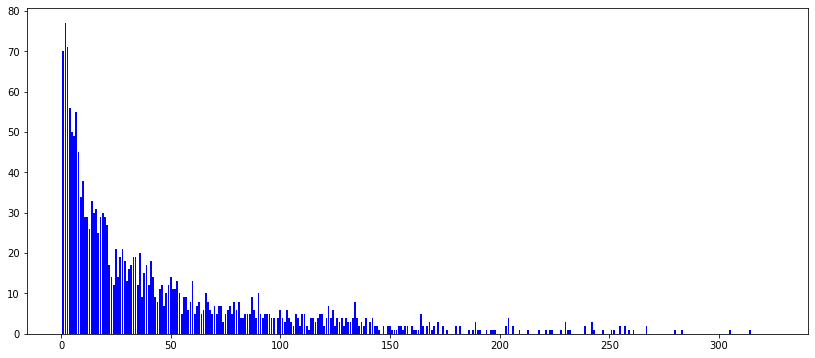

In [22]:
def des_pre1():#测试目的地的预测效果  
    """出行者历史中（任何起点）都未出现的潜在路段在嵌入排名中的表现"""
    luduanid=list(range(325))
    score_list=[]
    chaquan_list=[]
    pot_counter=Counter({})
    pot_road_list=[]
    real_road_list=[]
    ################创建历史出行目的地选择概率字典#####################
    for veh in time_spa_dict.keys():#遍历历史数据文件中的出行者
        ftroad_list=[i for time in time_spa_dict[veh] for i in time_spa_dict[veh][time]]  #该处行者所有的出行起点
        veh_index=gettensor(veh)    #由车牌号转为编号
        for time in time_spa_dict[veh]:#遍历该出行者所有的出行时间
            ttime=veh+'-'+time
            try:
                ttime_id=gettensor(ttime)
            except:
                ttime_id=0
            for froad in time_spa_dict[veh][time]:#遍历该出行者该时段选择的起点选择
                try:
                    froad_id=gettensor(froad)
                except:
                    froad_id=0
                troad_num=len(time_spa_dict[veh][time][froad])  #该出行者，该时间、该起点选择目的地的数量
                trip_num=sum(time_spa_dict[veh][time][froad].values()) #该o、t下的总出行量
                history_troad=list([(i,time_spa_dict[veh][time][froad][i]/trip_num) for i in time_spa_dict[veh][time][froad].keys()
                                   if time_spa_dict[veh][time][froad][i]>=1])  #历史出行记录，（路段，概率）  可调节发生量大于？进行距离衰减
                
                if len(history_troad)!=0:
                    history_troad=list(map(lambda x:(gettensor(x[0]),x[1]),history_troad))#将路段名称变为编码
                    history_troad_dict=dict(history_troad)  #转为字典
                    

                sort_scorelist=[]
    ##############################计算嵌入的距离###########################################
                for troad_id in luduanid:  #遍历325个路段
                    s_tuple=torch.tensor([[froad_id,ttime_id,troad_id]])
                    score=test_transD.scoreOp(s_tuple).item()    #模型在此处更改
                    sort_scorelist.append((troad_id,score))  #添加（路段编号，距离）
                    sort_scoredict=dict(sort_scorelist)   #转为字典
#                     print(sort_scoredict)
                if len(history_troad)!=0:
                    try:
                        for i in history_troad_dict.keys():
                            pass
#                             sort_scoredict[i]=sort_scoredict[i]*(1-history_troad_dict[i]) 
#                       
                        sort_scorelist=sorted(sort_scoredict.items(),key=lambda x:x[1])
#                         print(sort_scorelist)
                    
                        paiming_dict={k:i+1 for i,(k,v) in enumerate(sort_scorelist)}   #字典{路段编号：排名）
                        test_troad=list(map(gettensor,[i for i in time_spa_dict_test[veh][time][froad].keys()
                                   if time_spa_dict_test[veh][time][froad][i]>=1]))  #此处根据od发生次数筛选OD
#                         pot_road=set(test_troad)-history_troad_dict.keys()  #未在历史数据中出现过的路段集合
                        pot_road=history_troad_dict.keys()-set(test_troad)  #历史上中有但未在未来出现的
                        real_road=history_troad_dict.keys()
                        sub_list=[paiming_dict[i] for i in pot_road if i not in ftroad_list]  #w未出现过的路段在嵌入中的排名
                        sub_real_list=[paiming_dict[i] for i in real_road]
                        pot_road_list.extend(sub_list)   #潜在路段的排名
                        real_road_list.extend(sub_real_list)   #之前出现过的路段的嵌入排名
#                         print(test_troad)
                        predict_list=sort_scorelist[0:len(history_troad_dict)]  #对嵌入排名进行切片
                        predict_list=list(map(lambda x:x[0],predict_list))
                        predict_quwei=history_troad_dict.keys()-set([i[0] for i in paiming_dict.items() if i[1]>250]) #排除排名后几名的路段后的历史出行
                        predict_troad_set=set(predict_list)
#                       
                    
#                         scores=len(set(test_troad)&predict_troad_set)/len(predict_list)  #算法预测准确率
                        chaquan_scores=min(1,len(set(test_troad)&predict_troad_set)/len(test_troad))
#                         chaquan_scores=len((pot_road)&predict_troad_set)/len(pot_road)
#                         print(set(test_troad)-history_troad_dict.keys())
#                         scores=len((pot_road)&predict_troad_set)/len(predict_troad_set-history_troad_dict.keys())
                        scores=len(set(test_troad)&predict_quwei)/len(predict_quwei)
#                         print(len(right_troad))
#                         print(f'scores:{scores}')
#                         print(f'查全率:{chaquan_scores}')
                        score_list.append(scores)
                        chaquan_list.append(chaquan_scores)
                        print("准确率",end=":")
                        print(sum(score_list)/len(score_list))
                        print("查全率",end=":")
                        print(sum(chaquan_list)/len(chaquan_list))
                        print(sub_list)
                        
                    except:
                        continue
    pot_dict=dict(Counter(pot_road_list))   #不同出行者潜在出行在嵌入中的排名分布字典{排名：频次}
    real_dict=dict(Counter(real_road_list))
    for i in range(1,325):
        if i not in pot_dict.keys():
            pot_dict[i]=0
        if i not in real_dict.keys():
            real_dict[i]=0
    
    print(pot_dict)
    pot_dict=sorted(pot_dict.items(),key=lambda x :x[0])
    real_dict=sorted(real_dict.items(),key=lambda x :x[0])
#     print(real_dict)
#############作图#########################################################
    fig=plt.figure(figsize=(14,6))
    ax=fig.add_subplot(111)
    ax.bar([m[0] for m  in pot_dict],[m[1] for m  in pot_dict],color='b')
#     ax.bar([n[0] for n  in real_dict],[n[1] for n  in real_dict],color='r')
#     pro_list=[pot_dict[i][1]/real_dict[i][1]  if real_dict[i][1]!=0 else 1 for i in range(324)]
#     ax.plot(list(range(324)), pro_list)
                    
                                      
                    
#               print(sort_scorelist)
                    
des_pre1()

准确率:1.0
查全率:1.0
[2]
准确率:0.75
查全率:1.0
[4]
准确率:0.8333333333333334
查全率:1.0
[2]
准确率:0.875
查全率:1.0
[6]
准确率:0.9
查全率:1.0
[2]
准确率:0.9166666666666666
查全率:1.0
[2]
准确率:0.9285714285714286
查全率:0.9761904761904762
[1]
准确率:0.9375
查全率:0.9791666666666666
[2]
准确率:0.8333333333333334
查全率:0.9814814814814814
[]
准确率:0.85
查全率:0.9833333333333332
[30]
准确率:0.7727272727272727
查全率:0.9848484848484848
[]
准确率:0.7638888888888888
查全率:0.9444444444444443
[3, 22]
准确率:0.782051282051282
查全率:0.8717948717948717
[1]
准确率:0.7619047619047619
查全率:0.869047619047619
[1]
准确率:0.7777777777777778
查全率:0.861111111111111
[1]
准确率:0.7916666666666666
查全率:0.8541666666666666
[1]
准确率:0.8039215686274509
查全率:0.8333333333333333
[1]
准确率:0.8148148148148148
查全率:0.824074074074074
[1]
准确率:0.8245614035087719
查全率:0.8333333333333333
[27]
准确率:0.8083333333333332
查全率:0.7916666666666666
[2]
准确率:0.8174603174603173
查全率:0.8015873015873015
[4]
准确率:0.8257575757575757
查全率:0.8106060606060606
[24]
准确率:0.8115942028985507
查全率:0.8188405797101449
[49]
准确率:0.819444444444444

查全率:0.8214705882352942
[2]
准确率:0.8596491228070176
查全率:0.822514619883041
[5]
准确率:0.8604651162790697
查全率:0.823546511627907
[3]
准确率:0.861271676300578
查全率:0.8245664739884393
[9]
准确率:0.8620689655172413
查全率:0.8255747126436782
[34]
准确率:0.8628571428571429
查全率:0.8265714285714286
[4]
准确率:0.8636363636363636
查全率:0.8275568181818183
[2]
准确率:0.8625235404896421
查全率:0.8274011299435029
[3, 26]
准确率:0.8632958801498127
查全率:0.828370786516854
[2]
准确率:0.8621973929236498
查全率:0.8293296089385476
[8, 13]
准确率:0.8629629629629628
查全率:0.8302777777777779
[9]
准确率:0.863720073664825
查全率:0.8312154696132598
[18]
准确率:0.8644688644688644
查全率:0.8293956043956044
[1]
准确率:0.8652094717668487
查全率:0.8303278688524591
[26, 72]
准确率:0.8659420289855071
查全率:0.83125
[21]
准确率:0.8666666666666666
查全率:0.8321621621621622
[2]
准确率:0.8673835125448027
查全率:0.8330645161290323
[2]
准确率:0.8680926916221033
查全率:0.8312834224598932
[1]
准确率:0.8687943262411346
查全率:0.8321808510638299
[11, 6]
准确率:0.8694885361552027
查全率:0.8277777777777778
[1]
准确率:0.8701754385964

准确率:0.8796296296296297
查全率:0.8561776061776063
[21]
准确率:0.8799900199600799
查全率:0.8551112061591104
[1]
准确率:0.8788557213930349
查全率:0.855543710021322
[4]
准确率:0.8762400793650794
查全率:0.8559736394557824
[]
准确率:0.8766073194856578
查全率:0.8554118976967643
[2, 5]
准确率:0.8769723865877712
查全率:0.8558396731473656
[5]
准确率:0.8773352999016716
查全率:0.8562649248489957
[2]
准确率:0.8776960784313727
查全率:0.8566876750700282
[2]
准确率:0.8780547409579669
查全率:0.8571079458176234
[3]
准确率:0.8784113060428851
查全率:0.8575257588415485
[4, 3]
准确率:0.8787657920310982
查全率:0.8579411356379288
[3]
准确率:0.8791182170542636
查全率:0.8554471207087487
[1]
准确率:0.8794685990338165
查全率:0.8558661145617669
[16]
准确率:0.8798169556840078
查全率:0.8562826864849987
[2]
准确率:0.8801633045148896
查全率:0.8538150130369152
[1]
准确率:0.8776340996168583
查全率:0.8542350848385333
[]
准确率:0.8779847182425979
查全率:0.85465274935189
[6]
准确率:0.8754761904761905
查全率:0.8550680272108845
[]
准确率:0.8748812915479584
查全率:0.8554809388142723
[12, 8]
准确率:0.8752367424242425
查全率:0.855891504329004

准确率:0.8836700336700338
查全率:0.8631601731601735
[2]
准确率:0.8839045698924732
查全率:0.8634360599078343
[17]
准确率:0.8841381623071766
查全率:0.8637108364472552
[9]
准确率:0.8843708165997324
查全率:0.8639845094664375
[8]
准确率:0.8846025384101538
查全率:0.8642570855997712
[2]
准确率:0.8848333333333335
查全率:0.8645285714285716
[2]
准确率:0.8850632069194945
查全率:0.8647989734816085
[16]
准确率:0.8852921646746349
查全率:0.8650682982356291
[2]
准确率:0.8835321404903912
查全率:0.8653365521158765
[]
准确率:0.8837632275132277
查全率:0.8656037414965989
[19]
准确率:0.8839933993399341
查全率:0.8658698727015561
[2]
准确率:0.8842226613965746
查全率:0.8661349520045175
[5]
准确率:0.8844510190664038
查全率:0.8663989856297551
[2]
准确率:0.8846784776902888
查全率:0.8666619797525312
[18]
准确率:0.8849050425671252
查全率:0.8669239404995792
[23]
准确率:0.8851307189542486
查全率:0.8671848739495801
[3]
准确率:0.885355512067841
查全率:0.8674447861336317
[2]
准确率:0.8855794270833335
查全率:0.8677036830357145
[3]
准确率:0.8858024691358026
查全率:0.8679615705931498
[2]
准确率:0.8860246433203633
查全率:0.8682184546970542
[

查全率:0.879205624411104
[2]
准确率:0.889437689969605
查全率:0.8793892024895065
[6]
准确率:0.8896054628224584
查全率:0.8790664065322639
[8]
准确率:0.8897727272727275
查全率:0.8792496392496393
[2]
准确率:0.8899394856278368
查全率:0.879432317556372
[5]
准确率:0.8901057401812691
查全率:0.8796144439648972
[6]
准确率:0.8902714932126699
查全率:0.8782877253465489
[1]
准确率:0.8904367469879519
查全率:0.8784710269650029
[9]
准确率:0.8906015037593986
查全率:0.8779018976011457
[1]
准确率:0.8907657657657659
查全率:0.8765837265837266
[1]
准确率:0.8909295352323839
查全率:0.8767687584779039
[113]
准确率:0.8910928143712576
查全率:0.8769532363843741
[6]
准确率:0.8897608370702543
查全率:0.877137162787387
[]
准确率:0.8884328358208957
查全率:0.8773205401563611
[]
准确率:0.8885991058122208
查全率:0.8775033709459938
[4]
准确率:0.8887648809523812
查全率:0.8776856575963718
[3]
准确率:0.8889301634472513
查全率:0.8778674025330786
[9]
准确率:0.8890949554896144
查全率:0.87656492864208
[1]
准确率:0.8892592592592594
查全率:0.8767477954144621
[3]
准确率:0.8894230769230771
查全率:0.8769301211608904
[2]
准确率:0.8895864106351553
查全率:0.

{2: 160, 4: 49, 6: 40, 1: 126, 30: 5, 3: 94, 22: 4, 27: 5, 24: 7, 49: 2, 11: 14, 18: 8, 8: 29, 9: 23, 7: 25, 16: 11, 10: 10, 28: 3, 123: 1, 5: 28, 12: 14, 13: 16, 51: 3, 20: 5, 14: 8, 37: 2, 60: 4, 17: 11, 59: 2, 26: 5, 78: 1, 84: 2, 34: 2, 72: 2, 21: 8, 105: 1, 40: 1, 15: 9, 96: 1, 53: 2, 65: 1, 25: 4, 41: 2, 19: 3, 46: 3, 57: 1, 91: 1, 120: 1, 67: 2, 97: 1, 90: 2, 48: 2, 29: 3, 44: 3, 58: 1, 167: 1, 23: 6, 76: 1, 71: 1, 108: 2, 35: 4, 64: 2, 39: 1, 62: 1, 33: 1, 77: 1, 68: 1, 146: 1, 135: 1, 82: 1, 45: 1, 113: 1, 83: 1, 137: 1, 81: 1, 31: 0, 32: 0, 36: 0, 38: 0, 42: 0, 43: 0, 47: 0, 50: 0, 52: 0, 54: 0, 55: 0, 56: 0, 61: 0, 63: 0, 66: 0, 69: 0, 70: 0, 73: 0, 74: 0, 75: 0, 79: 0, 80: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 92: 0, 93: 0, 94: 0, 95: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 106: 0, 107: 0, 109: 0, 110: 0, 111: 0, 112: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 121: 0, 122: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 13

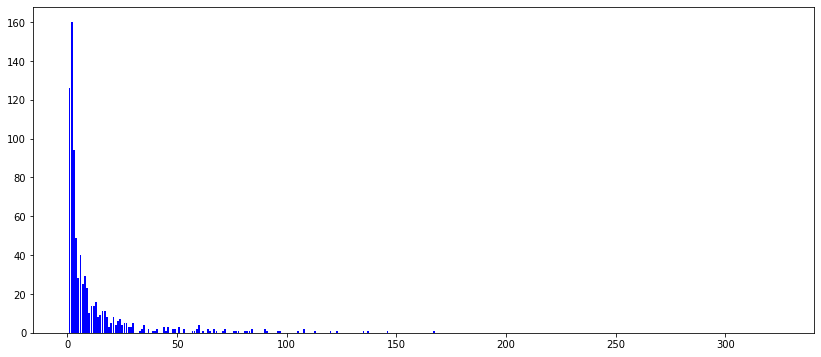

In [31]:
def des_pre11():#测试目的地的预测效果
    luduanid=list(range(325))
    score_list=[]
    chaquan_list=[]
    pot_counter=Counter({})
    pot_road_list=[]
    real_road_list=[]
    ################创建历史出行目的地选择概率字典#####################
    for veh in time_spa_dict.keys():#遍历历史数据文件中的出行者
        ftroad_list=[i for time in time_spa_dict[veh] for i in time_spa_dict[veh][time]]  #该处行者所有的出行起点
        veh_index=gettensor(veh)    #由车牌号转为编号
        for time in time_spa_dict[veh]:#遍历该出行者所有的出行时间
            ttime=veh+'-'+time
            try:
                ttime_id=gettensor(ttime)
            except:
                ttime_id=0
            for froad in time_spa_dict[veh][time]:#遍历该出行者该时段选择的起点选择
                try:
                    froad_id=gettensor(froad)
                except:
                    froad_id=0
                troad_num=len(time_spa_dict[veh][time][froad])  #该出行者，该时间、该起点选择目的地的数量
                trip_num=sum(time_spa_dict[veh][time][froad].values()) #该o、t下的总出行量
                history_troad=list([(i,time_spa_dict[veh][time][froad][i]/trip_num) for i in time_spa_dict[veh][time][froad].keys()
                                   if time_spa_dict[veh][time][froad][i]>=3])  #历史出行记录，（路段，概率）  可调节发生量大于？进行距离衰减
                
                if len(history_troad)!=0:
                    history_troad=list(map(lambda x:(gettensor(x[0]),x[1]),history_troad))#将路段名称变为编码
                    history_troad_dict=dict(history_troad)  #转为字典
                    

                sort_scorelist=[]
    ##############################计算嵌入的距离###########################################
                for troad_id in luduanid:  #遍历325个路段
                    s_tuple=torch.tensor([[froad_id,ttime_id,troad_id]])
                    score=test_transD.scoreOp(s_tuple).item()    #模型在此处更改
                    sort_scorelist.append((troad_id,score))  #添加（路段编号，距离）
                    sort_scoredict=dict(sort_scorelist)   #转为字典
#                     print(sort_scoredict)
                if len(history_troad)!=0:
                    try:
                        for i in history_troad_dict.keys():
                            pass
#                             sort_scoredict[i]=sort_scoredict[i]*(1-history_troad_dict[i]) 
#                       
                        sort_scorelist=sorted(sort_scoredict.items(),key=lambda x:x[1])
#                         print(sort_scorelist)
                    
                        paiming_dict={k:i+1 for i,(k,v) in enumerate(sort_scorelist)}   #字典{路段编号：排名）
                        test_troad=list(map(gettensor,[i for i in time_spa_dict_test[veh][time][froad].keys()
                                   if time_spa_dict_test[veh][time][froad][i]>=1]))  #此处根据od发生次数筛选OD
#                         pot_road=set(test_troad)-history_troad_dict.keys()  #未在历史数据中出现过的路段集合
                        pot_road=history_troad_dict.keys()&set(test_troad)  #历史上中有但未在未来出现的
                        real_road=history_troad_dict.keys()
                        sub_list=[paiming_dict[i] for i in pot_road if i not in ftroad_list]  #w未出现过的路段在嵌入中的排名
                        sub_real_list=[paiming_dict[i] for i in real_road]
                        pot_road_list.extend(sub_list)   #潜在路段的排名
                        real_road_list.extend(sub_real_list)   #之前出现过的路段的嵌入排名
#                         print(test_troad)
                        predict_list=sort_scorelist[0:len(history_troad_dict)]  #对嵌入排名进行切片
                        predict_list=list(map(lambda x:x[0],predict_list))
                        predict_quwei=history_troad_dict.keys()-set([i[0] for i in paiming_dict.items() if i[1]>250]) #排除排名后几名的路段后的历史出行
                        predict_troad_set=set(predict_list)
#                       
                    
#                         scores=len(set(test_troad)&predict_troad_set)/len(predict_list)  #算法预测准确率
                        chaquan_scores=min(1,len(set(test_troad)-predict_troad_set)/len(test_troad))
#                         chaquan_scores=len((pot_road)&predict_troad_set)/len(pot_road)
#                         print(set(test_troad)-history_troad_dict.keys())
#                         scores=len((pot_road)&predict_troad_set)/len(predict_troad_set-history_troad_dict.keys())
                        scores=len(set(test_troad)&predict_quwei)/len(predict_quwei)
#                         print(len(right_troad))
#                         print(f'scores:{scores}')
#                         print(f'查全率:{chaquan_scores}')
                        score_list.append(scores)
                        chaquan_list.append(chaquan_scores)
                        print("准确率",end=":")
                        print(sum(score_list)/len(score_list))
                        print("查全率",end=":")
                        print(sum(chaquan_list)/len(chaquan_list))
                        print(sub_list)
                        
                    except:
                        continue
    pot_dict=dict(Counter(pot_road_list))   #不同出行者潜在出行在嵌入中的排名分布字典{排名：频次}
    real_dict=dict(Counter(real_road_list))
    for i in range(1,325):
        if i not in pot_dict.keys():
            pot_dict[i]=0
        if i not in real_dict.keys():
            real_dict[i]=0
    
    print(pot_dict)
    pot_dict=sorted(pot_dict.items(),key=lambda x :x[0])
    real_dict=sorted(real_dict.items(),key=lambda x :x[0])
#     print(real_dict)
#############作图#########################################################
    fig=plt.figure(figsize=(14,6))
    ax=fig.add_subplot(111)
    ax.bar([m[0] for m  in pot_dict],[m[1] for m  in pot_dict],color='b')
#     ax.bar([n[0] for n  in real_dict],[n[1] for n  in real_dict],color='r')
#     pro_list=[pot_dict[i][1]/real_dict[i][1]  if real_dict[i][1]!=0 else 1 for i in range(324)]
#     ax.plot(list(range(324)), pro_list)
                    
                                      
                    
#               print(sort_scorelist)
                    
des_pre11()

In [ ]:
def des_pre3():#测试目的地的预测效果
    luduanid=list(range(325))
    score_list=[]
    chaquan_list=[]
    ################创建历史出行目的地选择概率字典#####################
    for veh in time_spa_dict.keys():#遍历历史数据文件中的出行者
        veh_index=gettensor(veh)    #由车牌号转为编号
        for time in time_spa_dict[veh]:#遍历该出行者所有的出行时间
            ttime=veh+'-'+time
            try:
                ttime_id=gettensor(ttime)
            except:
                ttime_id=0
            for froad in time_spa_dict[veh][time]:#遍历该出行者该时段选择的起点选择
                try:
                    froad_id=gettensor(froad)
                except:
                    froad_id=0
                troad_num=len(time_spa_dict[veh][time][froad])  #该出行者，该时间、该起点选择目的地的数量
                trip_num=sum(time_spa_dict[veh][time][froad].values()) #该o、t下的总出行量
                history_troad=list([(i,time_spa_dict[veh][time][froad][i]/trip_num) for i in time_spa_dict[veh][time][froad].keys()
                                   if time_spa_dict[veh][time][froad][i]==1])   #历史出行记录，（路段，概率）  可调节发生量大于？进行距离衰减
                #
#                 history_troad1=list([(i,time_spa_dict[veh][time][froad][i]/trip_num) for i in time_spa_dict[veh][time][froad].keys()
#                                    if time_spa_dict[veh][time][froad][i]>=2])
                if len(history_troad)!=0:
                    history_troad=list(map(lambda x:(gettensor(x[0]),x[1]),history_troad))#将路段名称变为编码
                    history_troad_dict=dict(history_troad)  #转为字典
                    
#                     history_troad1=list(map(lambda x:(gettensor(x[0]),x[1]),history_troad1))#将路段名称变为编码
#                     history_troad_dict1=dict(history_troad1)  #转为字典

#                 print(history_troad)
                sort_scorelist=[]
    ##############################计算嵌入的距离###########################################
                for troad_id in luduanid:  #遍历325个路段
                    s_tuple=torch.tensor([[froad_id,ttime_id,troad_id]])
                    score=test_transD.scoreOp(s_tuple).item()    #模型在此处更改
                    sort_scorelist.append((troad_id,score))  #添加（路段编号，距离）
                    sort_scoredict=dict(sort_scorelist)   #转为字典
#                     print(sort_scoredict)
                if len(history_troad)!=0:
                    try:
                        for i in history_troad_dict.keys():
#                             sort_scoredict[i]=sort_scoredict[i]*(1-history_troad_dict[i]) 
#                       
                        sort_scorelist=sorted(sort_scoredict.items(),key=lambda x:x[1])
#                         print(sort_scorelist)
                    
                        test_troad=list(map(gettensor,[i for i in time_spa_dict_test[veh][time][froad].keys()
                                   if time_spa_dict_test[veh][time][froad][i]>=1]))  #此处根据od发生次数筛选OD
                        
#                         print(test_troad)
                        predict_list=sort_scorelist[0:len(history_troad_dict)]
                        predict_list=list(map(lambda x:x[0],predict_list))
#                         print(list(history_troad_dict.keys()))
                        predict_troad_set=set(predict_list)
#                         print(len(set(test_troad)&history_troad_dict.keysys()))
                    
                        scores=len(set(test_troad)&history_troad_dict.keys())/len(history_troad_dict)  #算法预测准确率
                        chaquan_scores=min(1,len(set(test_troad)&predict_troad_set)/len(test_troad))
#                         print(set(test_troad)-history_troad_dict.keys())
#                         if len((predict_troad_set-history_troad_dict1.keys()))!=0:
#                             scores=len((predict_troad_set-history_troad_dict1.keys())&set(test_troad))/len((predict_troad_set-history_troad_dict1.keys()))#单纯的依据历史数据的准确率
                               
#                         print(len(right_troad))
#                         print(f'scores:{scores}')
#                         print(f'查全率:{chaquan_scores}')
                        score_list.append(scores)
                        chaquan_list.append(chaquan_scores)
                        print("准确率",end=":")
                        print(sum(score_list)/len(score_list))
                        print("查全率",end=":")
                        print(sum(chaquan_list)/len(chaquan_list))
                        
                    except:
                        continue
                    
                    
                                      
                    
#               print(sort_scorelist)
                    
des_pre3()

In [23]:
def des_pre2():#    测试历史出行中出行次数为1次的后续是否出行情况与嵌入表现的关系
    score_list=[]
    chaquan_list=[]
    test_trip_num_list=[]
    history_trip_num_list=[]
    ################创建历史出行目的地选择概率字典#####################
    for veh in time_spa_dict.keys():#遍历历史数据文件中的出行者
        for time in time_spa_dict[veh]:#遍历该出行者所有的出行时间
            for froad in time_spa_dict[veh][time]:#遍历该出行者该时段选择的起点选择
                troad_num=len(time_spa_dict[veh][time][froad])  #该出行者，该时间、该起点选择目的地的数量
                trip_num=sum(time_spa_dict[veh][time][froad].values()) #该o、t下的总出行量
                history_troad=list([(i,time_spa_dict[veh][time][froad][i]) for i in time_spa_dict[veh][time][froad].keys()
                                   if time_spa_dict[veh][time][froad][i]==1])   #历史出行记录，（路段，概率）  可调节发生量大于？进行距离衰减
                history_trip_num_list.append(sum([i[1] for i in history_troad]))
                if len(history_troad)!=0:
                    history_troad_dict=dict(history_troad)  #转为字典
                    

                sort_scorelist=[]
    ##############################计算嵌入的距离###########################################
                if len(history_troad)!=0:
                    try:
                        test_troad=list([i for i in time_spa_dict_test[veh][time][froad].keys()
                                   if time_spa_dict_test[veh][time][froad][i]>=1])   #所有的出行
                        test_trip_num=sum([time_spa_dict_test[veh][time][froad][i] 
                                       for i in time_spa_dict_test[veh][time][froad].keys()
                                   if time_spa_dict_test[veh][time][froad][i]>=1])
                        test_trip_num_list.append(test_trip_num)
                        
          
  #                         scores=len(set(test_troad)&predict_troad_set)/len(test_troad)  #算法预测准确率
                        scores=len(set(test_troad)&history_troad_dict.keys())/len(history_troad_dict)   #单纯的依据历史数据的准确率
                        chaquan_scores=min(1,len(set(test_troad)&history_troad_dict.keys())/len(test_troad))
                       
                        score_list.append(scores)
                        chaquan_list.append(chaquan_scores)
                        print("准确率",end=":")
                        print(sum(score_list)/len(score_list))
                        print("查全率",end=":")
                        print(sum(chaquan_list)/len(chaquan_list))
                    except:
                        continue
                else:
                    try:
                        len(list([i for i in time_spa_dict_test[veh][time][froad].keys()
                                   if time_spa_dict_test[veh][time][froad][i]>=1]))!=0
                        chaquan_list.append(0)
                    except:
                        continue
                   
                        
                        
    print(sum(test_trip_num_list))  #打印总出行量
    print(sum(history_trip_num_list))
                    
                    
                                      
                    
#               print(sort_scorelist)
                    
des_pre2()

{'id21215': 1, 'id8520': 1}
准确率:1.0
查全率:0.6666666666666666
{'id30020': 1}
{'id21214': 1}
{'id8520': 1}
准确率:0.5
查全率:0.2222222222222222
{'id21242': 1}
{'id30019': 1}
准确率:0.6666666666666666
查全率:0.41666666666666663
{'id1207': 1}
准确率:0.75
查全率:0.5333333333333333
{'id15342': 1}
准确率:0.8
查全率:0.611111111111111
{'id21215': 1}
{'id30055': 1}
{'id21144': 1}
准确率:0.6666666666666666
查全率:0.3333333333333333
{'id1005': 1}
准确率:0.7142857142857143
查全率:0.38888888888888884
{'id1041': 1}
{'id1065': 1}
准确率:0.625
查全率:0.31111111111111106
{'id1231': 1}
{'id1213': 1}
准确率:0.5555555555555556
查全率:0.29166666666666663
{'id1014': 1}
准确率:0.6
查全率:0.30392156862745096
{'id21214': 1, 'id30200': 1, 'id1065': 1}
准确率:0.6060606060606061
查全率:0.3055555555555555
{'id1231': 1}
准确率:0.638888888888889
查全率:0.3421052631578947
{'id1231': 1}
{'id1231': 1}
{'id1042': 1, 'id15342': 1, 'id1065': 1, 'id1215': 1}
准确率:0.5897435897435898
查全率:0.3095238095238095
{'id1231': 1}
{'id1008': 1, 'id1063': 1}
{'id1006': 1, 'id1065': 1}
准确率:0.54761904761904

{'id21243': 1, 'id30062': 1}
准确率:0.37984496124031003
查全率:0.26834862385321095
{'id1131': 1}
{'id21247': 1, 'id8785': 1}
{'id1131': 1}
准确率:0.38697318007662834
查全率:0.27499999999999997
{'id1043': 1}
{'id1130': 1, 'id1004': 1}
准确率:0.38257575757575757
查全率:0.2725225225225225
{'id15363': 1}
{'id15363': 1}
{'id30030': 1}
准确率:0.3782771535580524
查全率:0.2700892857142857
{'id1040': 1}
{'id1040': 1}
{'id1040': 1}
{'id30030': 1}
{'id1034': 1, 'id1006': 1}
准确率:0.3796296296296296
查全率:0.27654867256637167
{'id1023': 1}
{'id1023': 1, 'id1034': 1}
准确率:0.3864468864468864
查全率:0.28289473684210525
{'id1012': 1}
准确率:0.3822463768115942
查全率:0.28043478260869564
{'id30062': 1}
{'id1031': 1}
{'id21229': 1}
{'id1040': 1, 'id15342': 1}
准确率:0.38351254480286734
查全率:0.28663793103448276
{'id1034': 1}
准确率:0.37943262411347517
查全率:0.2841880341880342
{'id1130': 1}
{'id15342': 1}
{'id21211': 1}
准确率:0.38596491228070173
查全率:0.2902542372881356
{'id1043': 1}
准确率:0.3923611111111111
查全率:0.296218487394958
{'id21139': 1}
准确率:0.39862542

准确率:0.4013806706114399
查全率:0.29954954954954954
{'id8785': 1}
准确率:0.4049019607843138
查全率:0.30269058295964124
{'id21273': 1}
{'id8785': 1}
{'id21265': 1}
准确率:0.4083820662768032
查全率:0.30580357142857145
{'id21265': 1}
{'id30030': 1}
{'id21265': 1}
准确率:0.41182170542635665
查全率:0.3048245614035088
{'id21273': 1}
{'id8785': 1}
准确率:0.4152215799614644
查全率:0.3078602620087336
{'id21273': 1}
{'id21273': 1}
{'id21265': 1}
{'id21266': 1}
准确率:0.41858237547892724
查全率:0.3108695652173913
{'id1056': 1}
准确率:0.42190476190476195
查全率:0.31385281385281383
{'id8004': 1, 'id30030': 1, 'id1056': 1}
准确率:0.4214015151515152
查全率:0.3168103448275862
{'id30191': 1}
{'id21230': 1, 'id30191': 1}
{'id30030': 1}
{'id1130': 1}
准确率:0.41902071563088517
查全率:0.315450643776824
{'id30191': 1}
{'id1056': 1}
{'id30185': 1}
{'id30191': 1}
{'id1214': 1, 'id1056': 1, 'id30062': 1}
准确率:0.4166666666666667
查全率:0.3141025641025641
{'id21207': 1}
{'id30030': 1}
{'id30067': 1}
{'id30024': 1}
{'id30030': 1, 'id30194': 1}
{'id1056': 1}
{'id1097':

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




{'id1011': 1}
准确率:0.40130385487528347
查全率:0.2859086491739553
{'id1045': 1}
{'id30023': 1}
{'id21188': 1}
{'id30101': 1}
{'id30069': 1}
{'id1127': 1}
{'id21242': 1}
{'id30098': 1}
{'id21259': 1, 'id1028': 1, 'id1038': 1}
准确率:0.4010734463276836
查全率:0.2857263717669809
{'id21143': 1}
{'id21144': 1}
{'id1061': 1}
{'id1028': 1}
{'id21252': 1}
{'id21259': 1}
准确率:0.3997184684684685
查全率:0.28500301386377336
{'id1028': 1}
准确率:0.3983726150392817
查全率:0.2842833092833093
{'id8544': 1}
{'id21259': 1, 'id1028': 1}
准确率:0.39871364653243846
查全率:0.28608612210627327
{'id1018': 1}
{'id1018': 1}
{'id1018': 1}
{'id1018': 1}
{'id1018': 1}
{'id21257': 1}
准确率:0.39738015607580823
查全率:0.2853673127542474
{'id21259': 1}
准确率:0.39605555555555555
查全率:0.28465210645661776
{'id1018': 1}
{'id1018': 1}
{'id1018': 1}
{'id1099': 1}
{'id1058': 1, 'id1208': 1}
准确率:0.39473975636766334
查全率:0.2839404761904762
{'id1018': 1}
准确率:0.3967439293598234
查全率:0.2843081649533262
{'id1018': 1}
准确率:0.3987348734873487
查全率:0.2853733098177543
{'i

查全率:0.2976044703595724
{'id21227': 1}
准确率:0.4137333333333333
查全率:0.296998351275337
{'id21235': 1}
{'id21227': 1}
{'id21215': 1}
{'id21138': 1}
{'id21229': 1}
{'id21198': 1, 'id21227': 1}
{'id21236': 1}
准确率:0.4126329787234042
查全率:0.29639469608981805
{'id21229': 1}
{'id21138': 1}
{'id21206': 1}
{'id21207': 1}
{'id21138': 1}
{'id1003': 1}
准确率:0.41153846153846146
查全率:0.295793489809717
{'id21138': 1}
{'id21227': 1, 'id21229': 1, 'id1228': 1}
准确率:0.411331569664903
查全率:0.2962068633121265
{'id21227': 1}
{'id21206': 1}
{'id21265': 1}
{'id21206': 1}
{'id1049': 1}
{'id21188': 1}
{'id21227': 1}
{'id21233': 1}
准确率:0.41024626209322773
查全率:0.2956084656084656
{'id21194': 1}
{'id21138': 1}
{'id1051': 1}
{'id30203': 1}
准确率:0.4091666666666666
查全率:0.2950124807987711
{'id21265': 1}
{'id21188': 1}
{'id21266': 1}
{'id21229': 1}
{'id21229': 1}
{'id8005': 1}
{'id1215': 1}
{'id1013': 1}
准确率:0.408092738407699
查全率:0.2944188943182907
{'id21211': 1}
{'id1014': 1}
{'id1012': 1}
{'id8005': 1}
{'id1012': 1, 'id8005': 

KeyboardInterrupt: 

In [218]:
def des_pre4():#测试目的地的预测效果
    score_list=[]
    chaquan_list=[]
    test_trip_num_list=[]
    history_trip_num_list=[]
    
    ################创建历史出行目的地选择概率字典#####################
    for veh in time_spa_dict.keys():#遍历历史数据文件中的出行者
        froad_set=set()
        froadtest_set=set()
        try:
            for time in time_spa_dict[veh]:#遍历该出行者所有的出行时间
                for froad in time_spa_dict[veh][time]:#遍历该出行者该时段选择的起点选择
                    froad_set.add(froad)
                for froad1 in time_spa_dict_test[veh][time]:
                    froadtest_set.add(froad1)

        except:
            continue
        print(froadtest_set-froad_set)

#                 troad_num=len(time_spa_dict[veh][time][froad])  #该出行者，该时间、该起点选择目的地的数量
#                 trip_num=sum(time_spa_dict[veh][time][froad].values()) #该o、t下的总出行量
#                 history_troad=list([(i,time_spa_dict[veh][time][froad][i]) for i in time_spa_dict[veh][time][froad].keys()
#                                    if time_spa_dict[veh][time][froad][i]>=1])   #历史出行记录，（路段，概率）  可调节发生量大于？进行距离衰减
#                 history_trip_num_list.append(sum([i[1] for i in history_troad]))
#                 if len(history_troad)!=0:
#                     history_troad_dict=dict(history_troad)  #转为字典

#                 sort_scorelist=[]
#     ##############################计算嵌入的距离###########################################
#                 if len(history_troad)!=0:
#                     try:
#                         test_troad=list([i for i in time_spa_dict_test[veh][time][froad].keys()
#                                    if time_spa_dict_test[veh][time][froad][i]>=1]) 
#                         test_trip_num=sum([time_spa_dict_test[veh][time][froad][i]
#                                        for i in time_spa_dict_test[veh][time][froad].keys()
#                                    if time_spa_dict_test[veh][time][froad][i]>=1])
#                         test_trip_num_list.append(test_trip_num)
                        
          
#   #                         scores=len(set(test_troad)&predict_troad_set)/len(test_troad)  #算法预测准确率
#                         scores=len(set(test_troad)&history_troad_dict.keys())/len(history_troad_dict)   #单纯的依据历史数据的准确率
#                         chaquan_scores=min(1,len(set(test_troad)&history_troad_dict.keys())/len(test_troad))
                       
#                         score_list.append(scores)
#                         chaquan_list.append(chaquan_scores)
#                         print("准确率",end=":")
#                         print(sum(score_list)/len(score_list))
#                         print("查全率",end=":")
#                         print(sum(chaquan_list)/len(chaquan_list))
#                     except:
#                         continue
#     print(sum(test_trip_num_list))
#     print(sum(history_trip_num_list))
                    
                    
                                      
                    
#               print(sort_scorelist)
                    
des_pre4()

set()
set()
{'id30138'}
{'id8008', 'id1003', 'id1027', 'id8498'}
{'id21217', 'id21220', 'id1218'}
{'id1130', 'id1214', 'id21216'}
{'id1037'}
{'id8530', 'id21266'}
set()
{'id21259', 'id1015'}
{'id30103'}
{'id1032'}
{'id21219'}
{'id1025', 'id8544'}
{'id1042', 'id30200', 'id8004'}
{'id1207'}
{'id8520'}
{'id8507'}
{'id1054', 'id1050'}
{'id1058', 'id1018', 'id1007'}
{'id1037'}
set()
{'id1233', 'id21216', 'id1212', 'id1232'}
{'id21145'}
{'id21186', 'id30122', 'id1220', 'id1214'}
{'id21137', 'id1127', 'id21246'}
{'id1050', 'id1201'}
{'id1130', 'id1011', 'id1040'}
{'id1004', 'id21247', 'id1008', 'id1026', 'id30024', 'id1024', 'id21207'}
{'id30200'}
set()
{'id30024'}
set()
{'id30103'}
{'id1010', 'id1127', 'id21143', 'id1109', 'id1067'}
{'id1032', 'id30194', 'id21192', 'id21228'}
{'id1008'}
{'id8001'}
{'id1218'}
set()
{'id21220'}
set()
{'id1008'}
set()
{'id1002'}
{'id21248', 'id1210', 'id30200', 'id30182', 'id30193'}
{'id1097', 'id21230'}
set()
set()
{'id1022', 'id1021', 'id1002'}


In [ ]:
tl=[(i,1) for i in range(10)]
print(tl)
li=list(map(lambda x:(x[0]-1,x[1]),tl))
print(li)